In [2]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

  Using cached torchtext-0.6.0-py3-none-any.whl.metadata (6.3 kB)
Using cached torchtext-0.6.0-py3-none-any.whl (64 kB)
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.2
    Uninstalling torchtext-0.16.2:
      Successfully uninstalled torchtext-0.16.2
  Using cached pytorch_crf-0.7.2-py3-none-any.whl.metadata (2.4 kB)
Using cached pytorch_crf-0.7.2-py3-none-any.whl (9.5 kB)


In [3]:
import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import math
import random
import string
from itertools import chain

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = False) 
TAG = data.Field(unk_token = None) 

my_path = "/kaggle/input/data-ner"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )

MIN_FREQ = 1

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, 
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

.vector_cache/glove.6B.zip: 862MB [02:48, 5.13MB/s]                               
100%|█████████▉| 399999/400000 [01:08<00:00, 5831.01it/s]


In [5]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 14986
Number of validation examples: 3465
Number of testing examples: 3683


In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.6, max_len=700):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
class Transformer(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 attn_heads,
                 fc_hidden,
                 trf_layers,
                 output_dim,
                 emb_dropout,
                 trf_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):  
        super().__init__()
        
        self.word_pad_idx = word_pad_idx
        self.tag_pad_idx = tag_pad_idx

        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim= embedding_dim,
            padding_idx=word_pad_idx
        )

        self.emb_dropout = nn.Dropout(emb_dropout)
        all_emb_size = embedding_dim 
        self.position_encoder = PositionalEncoding(
            d_model=all_emb_size
        )
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=all_emb_size,
            nhead=attn_heads,
            activation="relu",
            dropout=trf_dropout
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layers,
            num_layers=trf_layers
        )
        
        self.fc1 = nn.Linear(
            in_features=all_emb_size,
            out_features=fc_hidden
        )
        self.fc1_gelu = nn.GELU()
        self.fc1_norm = nn.LayerNorm(fc_hidden)
        self.fc2_dropout = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(
            in_features=fc_hidden,
            out_features=output_dim
        )

        self.crf = CRF(num_tags=output_dim)
        
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)
            
    def forward(self, words, tags=None):
        embedding_out = self.emb_dropout(self.embedding(words))

        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        
        pos_out = self.position_encoder(embedding_out)
        enc_out = self.encoder(pos_out, src_key_padding_mask=key_padding_mask)
        
        fc1_out = self.fc1_norm(self.fc1_gelu(self.fc1(enc_out)))
        fc2_out = self.fc2(self.fc2_dropout(fc1_out))
     
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc2_out, mask=crf_mask)
        crf_loss = -self.crf(fc2_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss
    
    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            if tag_name[0] == "I" or tag_name[0] == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )
                            
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad) 

In [8]:
model = Transformer(
    input_dim = len(TEXT.vocab),
    embedding_dim = 300,
    attn_heads = 4,  
    fc_hidden = 64,  
    trf_layers = 1,
    output_dim = len(TAG.vocab),
    emb_dropout = 0.2,
    trf_dropout = 0.2,
    fc_dropout = 0.5,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX,
)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[TAG_PAD_IDX] = torch.zeros(300)

model.init_crf_transitions(
    tag_names = TAG.vocab.itos
)
print(f"Model has {model.count_parameters():,} parametres")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model has 8,701,510 parametres


In [9]:
def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

In [10]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [11]:
def train(model, iterator, optimizer, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)
        
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

In [12]:
def evaluate(model, iterator, tag_pad_idx,full_report):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
N_EPOCHS = 150

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
   
    
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    #scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model_conll.pt')
    
 
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 655.994 | Train F1 score: 0.15%
	 Val. Loss: 651.963 |  Val. F1 score: 0.00%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 353.093 | Train F1 score: 13.67%
	 Val. Loss: 832.079 |  Val. F1 score: 0.04%
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 292.685 | Train F1 score: 25.42%
	 Val. Loss: 898.045 |  Val. F1 score: 3.71%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 266.516 | Train F1 score: 31.20%
	 Val. Loss: 932.879 |  Val. F1 score: 5.72%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 251.260 | Train F1 score: 33.74%
	 Val. Loss: 909.029 |  Val. F1 score: 9.01%
Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 237.037 | Train F1 score: 37.09%
	 Val. Loss: 943.471 |  Val. F1 score: 10.62%
Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 227.422 | Train F1 score: 38.80%
	 Val. Loss: 894.369 |  Val. F1 score: 12.87%
Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 218.561 | Train F1 score: 40.48%
	 Val. Loss: 939.502 |  Val. F1 score: 14.53%
Epoch: 09 | Epoch Time

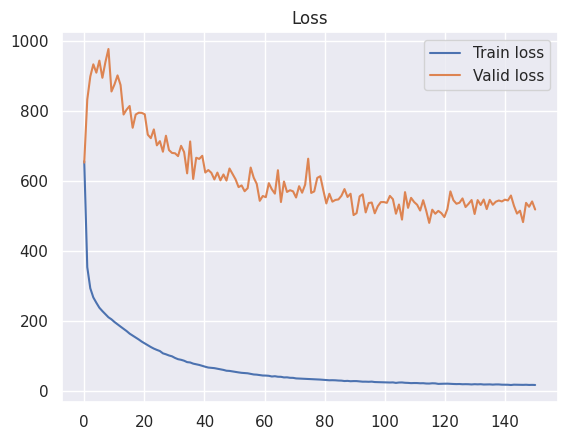

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

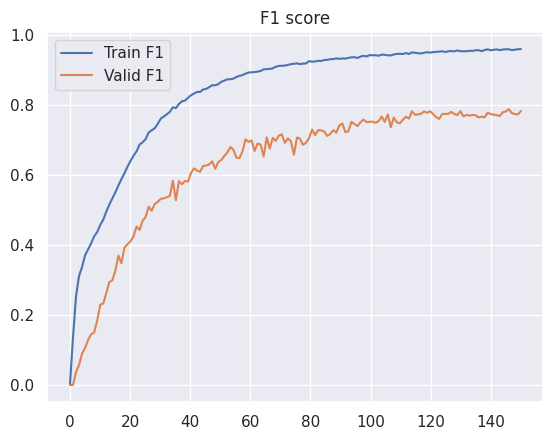

In [16]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [17]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut5-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 657.475 |  Test F1 score: 66.79%


In [18]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

In [19]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in TAG.vocab.itos][1:]
s = pd.Series([i for i in TAG.vocab.itos][1:])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O' and i != '<pad>'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O' and i != '<pad>'])

confusion_df

,O,LOC,PER,ORG,MISC
O,38406,13,8,45,48
LOC,297,1529,4,75,19
PER,1761,28,952,27,4
ORG,743,201,31,1479,40
MISC,267,11,6,11,620


In [20]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.926026,0.997040,0.960222
LOC,0.858025,0.794699,0.825148
PER,0.951049,0.343434,0.504638
ORG,0.903482,0.593023,0.716049
MISC,0.848153,0.677596,0.753341


In [21]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load("en_core_web_sm")
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [22]:
example_index = 15

sentence = vars(test_data.examples[example_index])['text']
actual_tags = vars(test_data.examples[example_index])['tag']

print(sentence)
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG
                                       )

print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4   
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

['Japan', 'then', 'laid', 'siege', 'to', 'the', 'Syrian', 'penalty', 'area', 'for', 'most', 'of', 'the', 'game', 'but', 'rarely', 'breached', 'the', 'Syrian', 'defence', '.']
Pred. Tag				Actual Tag				Correct?				Token

B-LOC 				 B-LOC 				 ✔ 					 Japan
O 					 O 					 ✔ 					 then
O 					 O 					 ✔ 					 laid
O 					 O 					 ✔ 					 siege
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 the
B-MISC 				 B-MISC 				 ✔ 					 Syrian
O 					 O 					 ✔ 					 penalty
O 					 O 					 ✔ 					 area
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 most
O 					 O 					 ✔ 					 of
O 					 O 					 ✔ 					 the
O 					 O 					 ✔ 					 game
O 					 O 					 ✔ 					 but
O 					 O 					 ✔ 					 rarely
O 					 O 					 ✔ 					 breached
O 					 O 					 ✔ 					 the
B-MISC 				 B-MISC 				 ✔ 					 Syrian
O 					 O 					 ✔ 					 defence
O 					 O 					 ✔ 					 .


In [23]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'
tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG
                                )

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    space = 2 if tag == 'O'else 1
    print(tag, "\t"*space, token)

[]
Pred. Tag	Token

O 		 The
O 		 will
O 		 deliver
O 		 a
O 		 speech
O 		 about
O 		 the
O 		 conflict
O 		 in
B-LOC 	 North
I-LOC 	 Korea
O 		 tomorrow
O 		 in
B-LOC 	 New
I-LOC 	 York
O 		 with
O 		 my
O 		 friend
B-PER 	 Mary
I-PER 	 Kate
O 		 .


# Fine-Tuning

In [24]:
from datasets import load_dataset

dataset = load_dataset('conll2003')

dataset

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [25]:
label_names = dataset['train'].features['ner_tags'].feature.names

label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [26]:
from transformers import AutoTokenizer

checkpoint = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [27]:
def align_target(labels, word_ids):
    begin2inside = {
        1: 2,  # B-LOC -> I-LOC
        3: 4,  # B-MISC -> I-MISC
        5: 6,  # B-ORG -> I-ORG
        7: 8    # B-PER -> I-PER
    }

    align_labels = []
    last_word = None
    
    for word in word_ids:
        if word is None:
            label = -100 
        elif word != last_word:
            label = labels[word]  
        else:
            label = labels[word]
            if label in begin2inside:
                label = begin2inside[label]  

        align_labels.append(label)
        last_word = word

    return align_labels


In [28]:
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

    labels_batch = batch['ner_tags']

    aligned_targets_batch = []

    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i)
        
        aligned_targets_batch.append(align_target(labels, word_ids))

    tokenized_inputs["labels"] = aligned_targets_batch

    return tokenized_inputs

In [29]:
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [30]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

batch = data_collator([tokenized_dataset['train'][i] for i in range(2)])

batch

2024-08-05 21:15:38.933108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 21:15:38.933225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 21:15:39.063753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102],
        [  101,  1943, 14428,   102,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])}

In [31]:
!pip install seqeval

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=12794d873ee93be9b64027e59f48352988c136f192f88926f4a4a91733d33c27
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [32]:
from datasets import load_metric  

metric = load_metric("seqeval")

 
metric.compute(predictions = [['O' , 'B-ORG' , 'I-ORG']], 
               references = [['O' , 'B-MISC' , 'I-ORG']])

/tmp/ipykernel_34/2879304908.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


The repository for seqeval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/seqeval.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.6666666666666666}

In [33]:
def compute_metrics(logits_and_labels):

    logits, labels = logits_and_labels 

    predictions = np.argmax(logits, axis=-1)

    str_labels = [[label_names[t] for t in label if t!=-100] for label in labels]

    str_preds = [
    [label_names[p] for (p, t) in zip(prediction, label) if t != -100]
      for prediction, label in zip(predictions, labels)
    ]
    
    results = metric.compute(predictions=str_preds, references=str_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"], 
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]  
    }

In [34]:
id2label = {k: v for k, v in enumerate(label_names)} 

label2id = {v: k for k, v in enumerate(label_names)}

print(id2label , '\n--------------------\n' , label2id)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'} 
--------------------
 {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


In [35]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
  checkpoint,
  id2label=id2label,  
  label2id=label2id
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "fine_tuned_model",
    eval_strategy = "epoch",
    learning_rate = 2e-5, 
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 10,
    weight_decay = 0.01
)   

In [37]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator 
)

In [38]:
import numpy as np

In [39]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.244900,0.098367,0.844040,0.888926,0.865902,0.969491
2,0.061100,0.084336,0.903322,0.919892,0.911532,0.979470
3,0.033000,0.071597,0.903257,0.928644,0.915775,0.981015
4,0.021200,0.072684,0.907216,0.933019,0.919937,0.982545
5,0.013200,0.074604,0.909417,0.937731,0.923357,0.983178
6,0.007600,0.089540,0.909819,0.937227,0.923319,0.982281
7,0.005400,0.089945,0.920481,0.940929,0.930593,0.984150
8,0.004300,0.090122,0.918280,0.941770,0.929877,0.983723
9,0.002500,0.094730,0.918777,0.940424,0.929474,0.983870
10,0.001400,0.093838,0.919376,0.942275,0.930685,0.984179


TrainOutput(global_step=8780, training_loss=0.03293985646718727, metrics={'train_runtime': 716.5794, 'train_samples_per_second': 195.945, 'train_steps_per_second': 12.253, 'total_flos': 1754504273305224.0, 'train_loss': 0.03293985646718727, 'epoch': 10.0})

In [44]:
trainer.evaluate()

{'eval_loss': 0.09383777529001236,
 'eval_precision': 0.919376026272578,
 'eval_recall': 0.9422753281723325,
 'eval_f1': 0.9306848404255319,
 'eval_accuracy': 0.9841790781185612,
 'eval_runtime': 5.9737,
 'eval_samples_per_second': 544.054,
 'eval_steps_per_second': 34.15,
 'epoch': 10.0}

In [40]:
trainer.save_model('fine_tuned_model')

In [41]:
from transformers import pipeline

ner = pipeline(
    'token-classification',
    model = 'fine_tuned_model',
    aggregation_strategy = 'simple' , 
    device = 0 
)

In [42]:
ner('Apple Inc. is planning to open a new store in San Francisco, California.')

[{'entity_group': 'ORG',
  'score': 0.9998166,
  'word': 'Apple Inc.',
  'start': 0,
  'end': 10},
 {'entity_group': 'LOC',
  'score': 0.9997673,
  'word': 'San Francisco',
  'start': 46,
  'end': 59},
 {'entity_group': 'LOC',
  'score': 0.9998286,
  'word': 'California',
  'start': 61,
  'end': 71}]